In [1]:
import pywt
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as  sts
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

ModuleNotFoundError: No module named 'pmdarima'

# Data Sourcing

In [2]:
raw_data = yfinance.download(
                    tickers=["INFY.BO", "TCS.BO", "^BSESN", "WIPRO.BO"],
                    start="2012-08-14",
                    group_by="ticker",
                    auto_adjust=True,
                    interval="1d",
                    threads=True,
                    )

[*********************100%***********************]  4 of 4 completed


In [3]:
df = raw_data.copy()

In [4]:
df.tail()

WIPRO.BO                                              \
                  Open        High         Low       Close  Volume   
Date                                                                 
2023-02-20  404.049988  407.850006  402.250000  406.950012   87702   
2023-02-21  406.250000  408.000000  402.100006  402.750000  138432   
2023-02-22  399.000000  400.500000  394.500000  395.200012  272207   
2023-02-23  395.450012  398.700012  393.299988  393.950012  273861   
2023-02-24  396.000000  396.500000  392.649994  393.299988  159432   

                  ^BSESN                                                    \
                    Open          High           Low         Close  Volume   
Date                                                                         
2023-02-20  61112.839844  61290.191406  60607.019531  60691.539062  6100.0   
2023-02-21  60770.429688  60976.589844  60583.718750  60672.718750  5100.0   
2023-02-22  60391.859375  60462.898438  59681.550781  59744.980469  8100.0   
2023-02-23  59777.640625  59960.039062  59406.308594  59605.800781  7100.0   
2023-02-24  59859.480469  59908.769531  59325.339844  59463.929688  5300.0   

                INFY.BO                                                 \
                   Open         High          Low        Close  Volume   
Date                                                                     
2023-02-20  1589.000000  1602.449951  1582.599976  1593.250000  134312   
2023-02-21  1599.000000  1601.150024  1575.900024  1579.250000  243750   
2023-02-22  1564.000000  1575.000000  1556.050049  1562.550049  155848   
2023-02-23  1570.000000  1570.000000  1548.000000  1551.500000  220637   
2023-02-24  1555.050049  1569.000000  1546.699951  1551.449951  327566   

                 TCS.BO                                                 
                   Open         High          Low        Close  Volume  
Date                                                                    
2023-02-20  3506.000000  3522.000000  3475.199951  3486.100098   43050  
2023-02-21  3489.000000  3507.949951  3445.000000  3449.399902  102243  
2023-02-22  3424.899902  3447.550049  3395.100098  3400.550049   41593  
2023-02-23  3410.500000  3453.750000  3408.000000  3414.100098   41914  
2023-02-24  3421.199951  3434.000000  3382.550049  3400.050049   35329

In [5]:
df["wipro"] = df["WIPRO.BO"].Close
df["bse"] = df["^BSESN"].Close
df["infy"] = df["INFY.BO"].Close
df["tcs"] = df["TCS.BO"].Close

In [6]:
del  df["TCS.BO"], df["^BSESN"], df["WIPRO.BO"], df["INFY.BO"]

In [7]:
df.head()

,wipro,bse,infy,tcs
,,,,
Date,,,,
2012-08-14,121.136482,17728.199219,227.483154,511.784698
2012-08-16,119.209625,17657.210938,225.950272,509.424896
2012-08-17,120.607864,17691.080078,229.577423,515.334656
2012-08-21,121.204697,17885.259766,235.010757,523.786255
2012-08-22,120.795441,17846.859375,237.192886,521.224670


# Data Preprocessing

In [8]:
df.asfreq('b')

,wipro,bse,infy,tcs
,,,,
Date,,,,
2012-08-14,121.136482,17728.199219,227.483154,511.784698
2012-08-15,NaN,NaN,NaN,NaN
2012-08-16,119.209625,17657.210938,225.950272,509.424896
2012-08-17,120.607864,17691.080078,229.577423,515.334656
2012-08-20,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-02-20,406.950012,60691.539062,1593.250000,3486.100098
2023-02-21,402.750000,60672.718750,1579.250000,3449.399902


In [9]:
df.isna().sum()

wipro       0
bse        12
infy        0
tcs         0
dtype: int64

In [10]:
df.fillna(method='bfill',inplace=True)

In [11]:
df.isna().sum()

wipro      0
bse        0
infy       0
tcs        0
dtype: int64

In [12]:
df_ret = pd.DataFrame()

In [13]:
df_ret['ret_bse'] = df['bse'].pct_change(1).mul(100)
df_ret['ret_infy'] = df['infy'].pct_change(1).mul(100)
df_ret['ret_wipro'] = df['wipro'].pct_change(1).mul(100)
df_ret['ret_tcs'] = df['tcs'].pct_change(1).mul(100)

In [14]:
df_diff = df.diff()

In [15]:
df_seasonal_diff = df.diff(periods=5).diff()

In [16]:
df_seasonal_diff.head(10)

,wipro,bse,infy,tcs
,,,,
Date,,,,
2012-08-14,NaN,NaN,NaN,NaN
2012-08-16,NaN,NaN,NaN,NaN
2012-08-17,NaN,NaN,NaN,NaN
2012-08-21,NaN,NaN,NaN,NaN
2012-08-22,NaN,NaN,NaN,NaN
2012-08-23,NaN,NaN,NaN,NaN
2012-08-24,2.455475,3.978516,-1.020203,3.106201
2012-08-27,-2.728271,-138.269531,-7.024872,-7.462982


In [17]:
df_diff.head()

,wipro,bse,infy,tcs
,,,,
Date,,,,
2012-08-14,NaN,NaN,NaN,NaN
2012-08-16,-1.926857,-70.988281,-1.532883,-2.359802
2012-08-17,1.398239,33.869141,3.627151,5.909760
2012-08-21,0.596832,194.179688,5.433334,8.451599
2012-08-22,-0.409256,-38.400391,2.182129,-2.561584


In [18]:
df_ret.head()

,ret_bse,ret_infy,ret_wipro,ret_tcs
Date,,,,
2012-08-14,NaN,NaN,NaN,NaN
2012-08-16,-0.400426,-0.673844,-1.590650,-0.461093
2012-08-17,0.191815,1.605288,1.172925,1.160085
2012-08-21,1.097614,2.366668,0.494854,1.640021
2012-08-22,-0.214704,0.928523,-0.337657,-0.489051


In [19]:
df.head()

,wipro,bse,infy,tcs
,,,,
Date,,,,
2012-08-14,121.136482,17728.199219,227.483154,511.784698
2012-08-16,119.209625,17657.210938,225.950272,509.424896
2012-08-17,120.607864,17691.080078,229.577423,515.334656
2012-08-21,121.204697,17885.259766,235.010757,523.786255
2012-08-22,120.795441,17846.859375,237.192886,521.224670


## Train-Test Split

In [20]:
train_i = int(len(df) * 0.8)

In [21]:
df_train, df_test = df.iloc[:train_i], df.iloc[train_i:]

In [22]:
df_train.tail()

,wipro,bse,infy,tcs
,,,,
Date,,,,
2021-01-15,432.035248,49034.671875,1291.117310,3098.357910
2021-01-18,425.284698,48564.269531,1259.009644,3086.093262
2021-01-19,424.052887,49398.289062,1264.192993,3128.588135
2021-01-20,438.490234,49792.121094,1285.693848,3169.837402
2021-01-21,439.426361,49624.761719,1285.502075,3137.834717


In [23]:
df_test.head()

,wipro,bse,infy,tcs
,,,,
Date,,,,
2021-01-22,439.722717,48878.539062,1286.653809,3165.238281
2021-01-25,431.870544,48347.589844,1269.520142,3152.590332
2021-01-27,440.759796,47409.929688,1249.506958,3124.659424
2021-01-28,426.438171,46874.359375,1225.078369,3065.635986
2021-01-29,412.906738,46285.769531,1189.899414,2982.705811


# Data Visualization

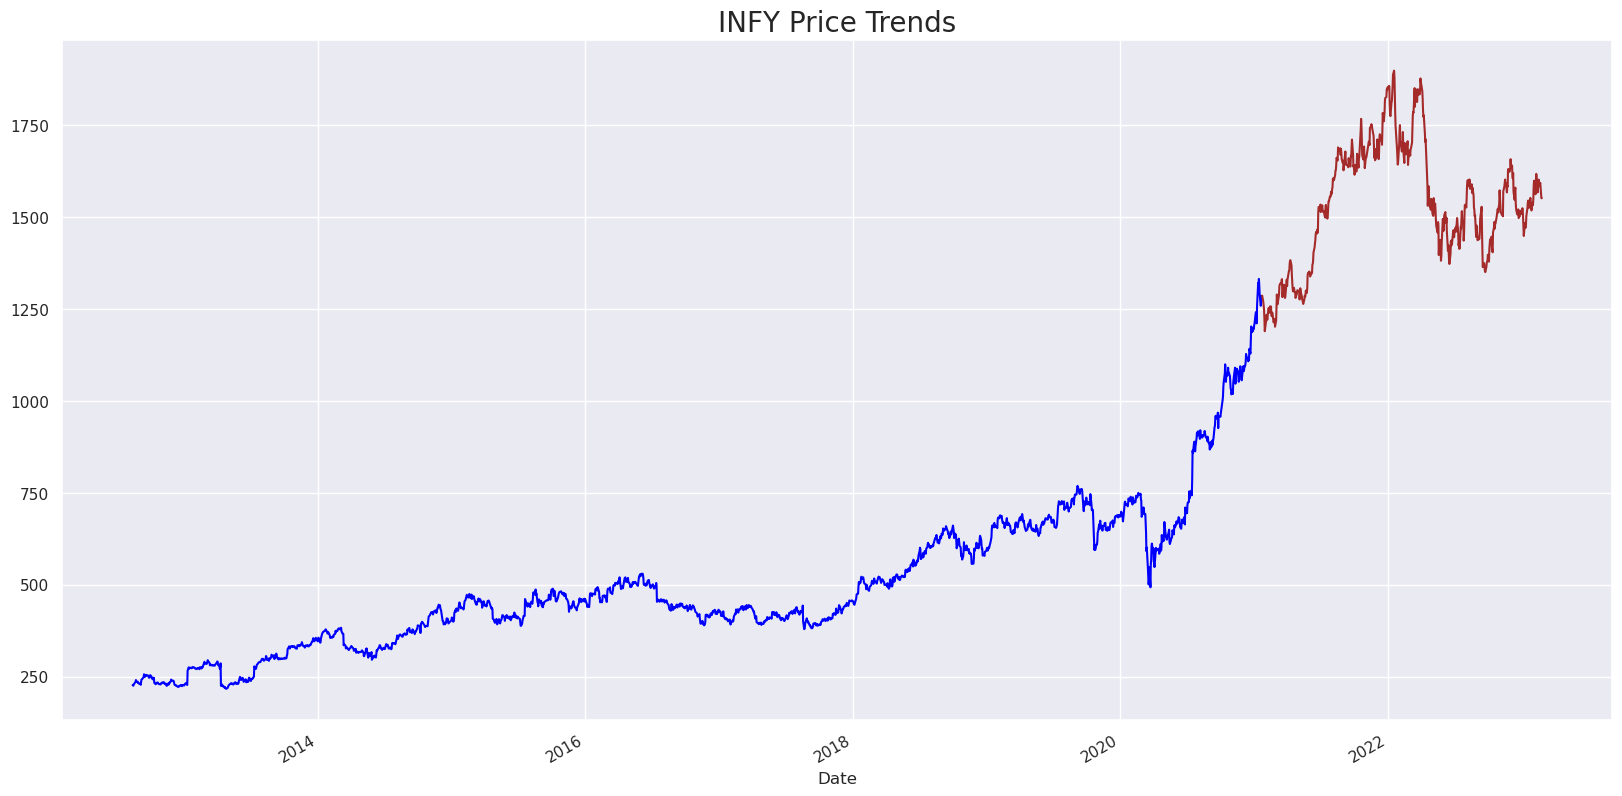

In [24]:
df_train.infy.plot(figsize=(20,10),color='blue')
df_test.infy.plot(color='brown')
plt.title("INFY Price Trends",size=20)
plt.show()

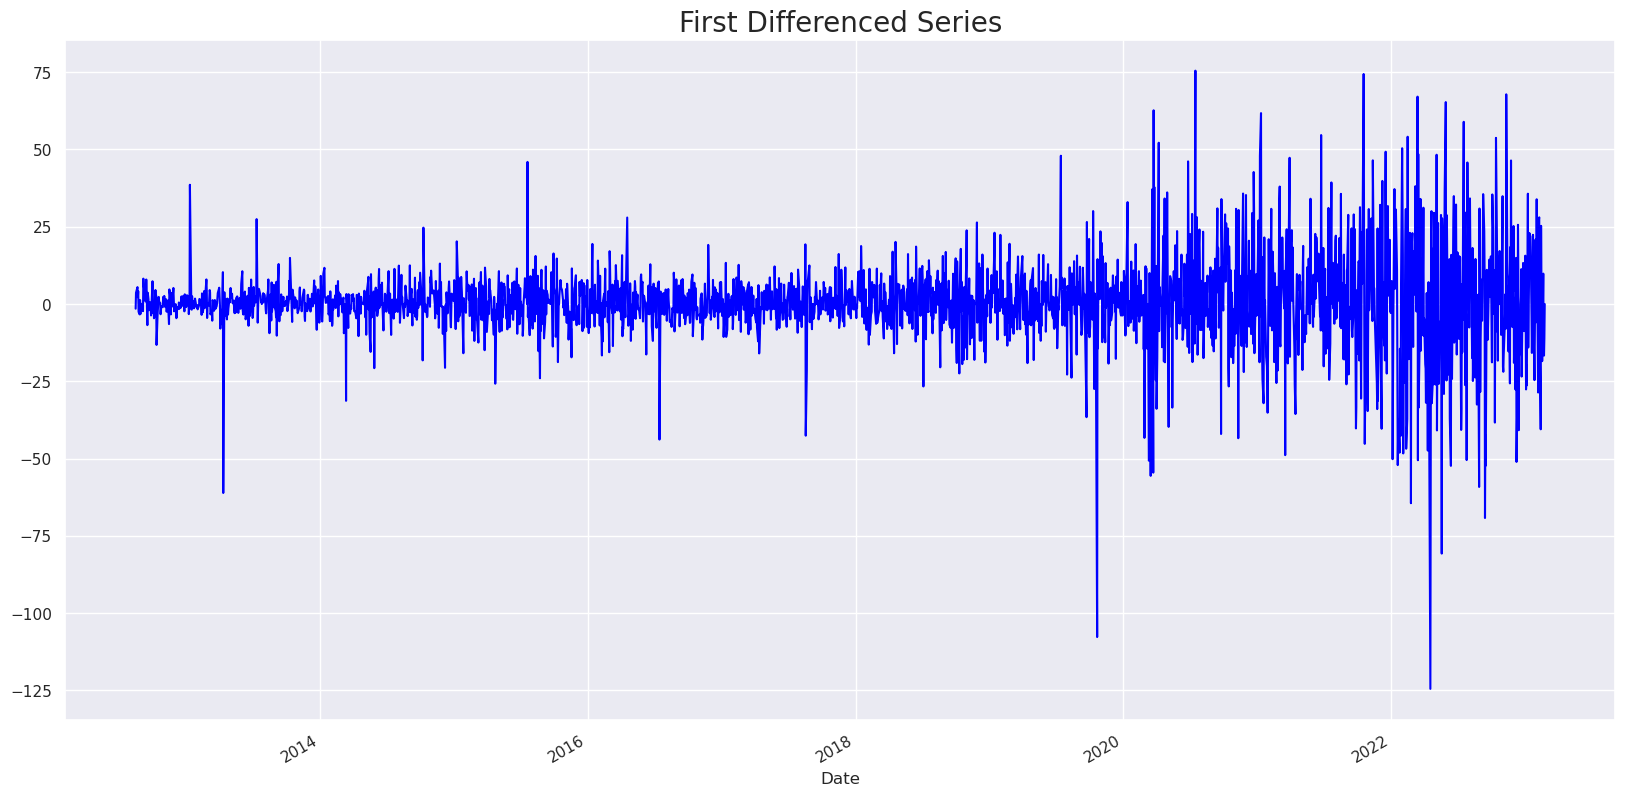

In [25]:
df_diff.infy.plot(figsize=(20,10),color='blue')
plt.title("First Differenced Series",size=20)
plt.show()

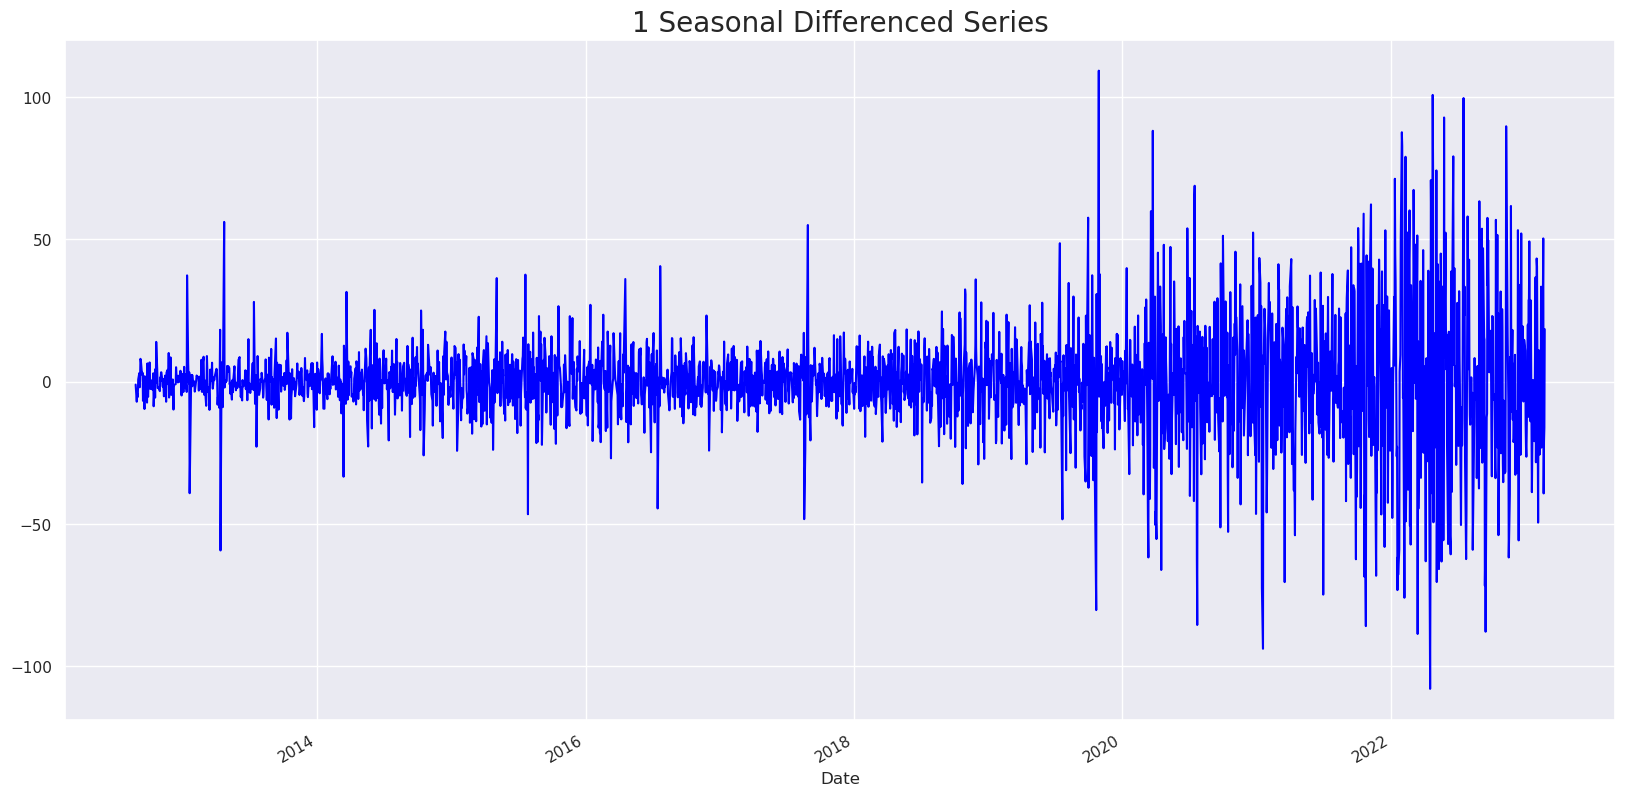

In [26]:
df_seasonal_diff.infy.plot(figsize=(20,10),color='blue')
plt.title("1 Seasonal Differenced Series",size=20)
plt.show()

# Stationarity Test

In [27]:
sts.adfuller(df.infy)

(0.15247668353897684,
 0.9694665988679461,
 27,
 2569,
 {'1%': -3.4328980132719673,
  '5%': -2.862665712019849,
  '10%': -2.567369257851913},
 20710.371472372513)

Adf fuller statistic of INFY prices is larger than corresponding critical value , hence it is not stationary

In [28]:
sts.adfuller(df_diff.infy[1:])

(-10.555530591529884,
 7.970719655285681e-19,
 26,
 2569,
 {'1%': -3.4328980132719673,
  '5%': -2.862665712019849,
  '10%': -2.567369257851913},
 20701.307921184773)

*Adf fuller statistic of First Differenced series is much lower than critical value, hence it is stationary*

In [29]:
sts.adfuller(df_seasonal_diff.infy[7:])

(-12.975707645866402,
 3.0158680985184325e-24,
 28,
 2561,
 {'1%': -3.4329059807036155,
  '5%': -2.8626692305213957,
  '10%': -2.5673711311351712},
 21042.40686553061)

*Adf fuller statistic of 1 Seasonal Differenced series is much lower than critical value, hence it is stationary*

# ACF PACF Plots

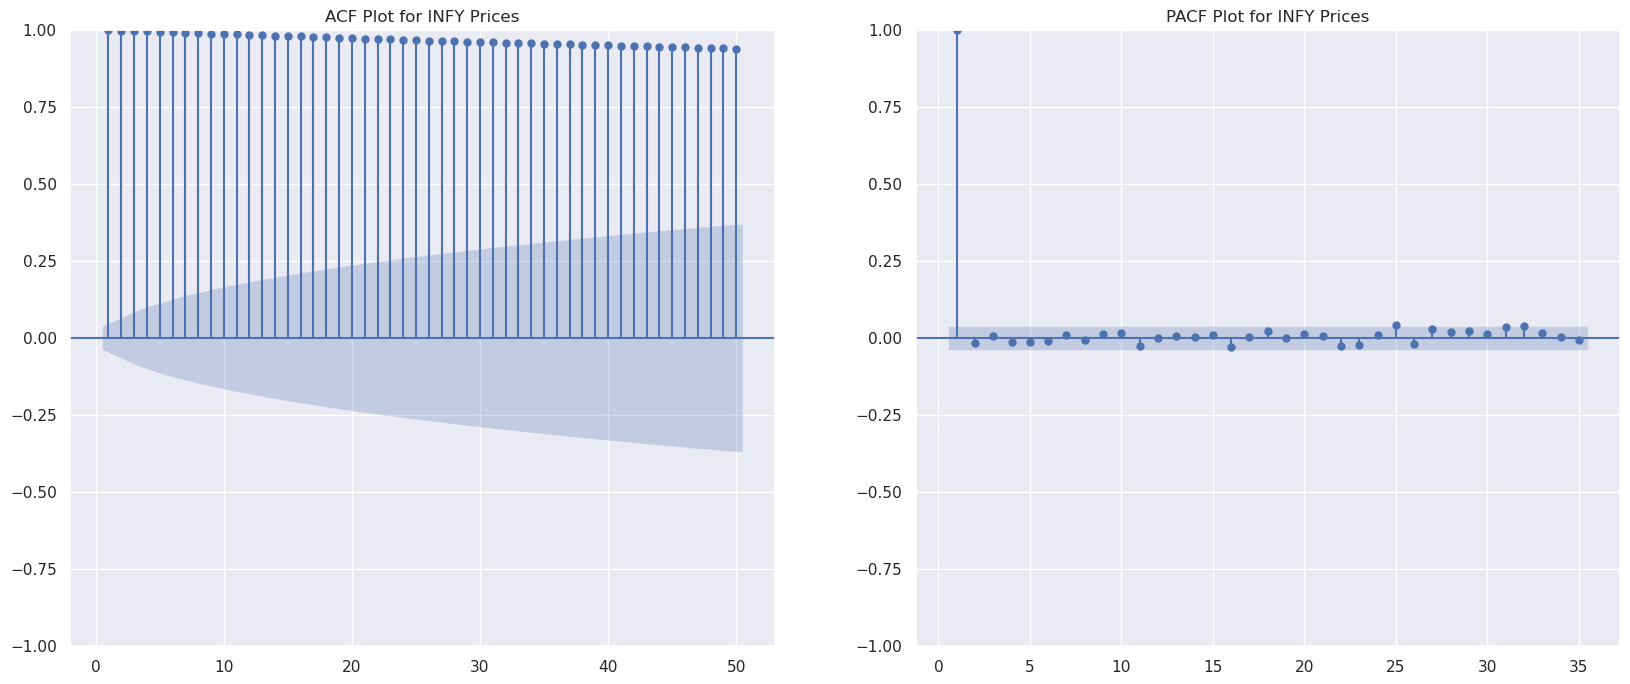

In [30]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
sgt.plot_acf(df.infy,ax=ax[0],title='ACF Plot for INFY Prices',zero=False,lags=50);
sgt.plot_pacf(df.infy,ax=ax[1],title='PACF Plot for INFY Prices',zero=False);

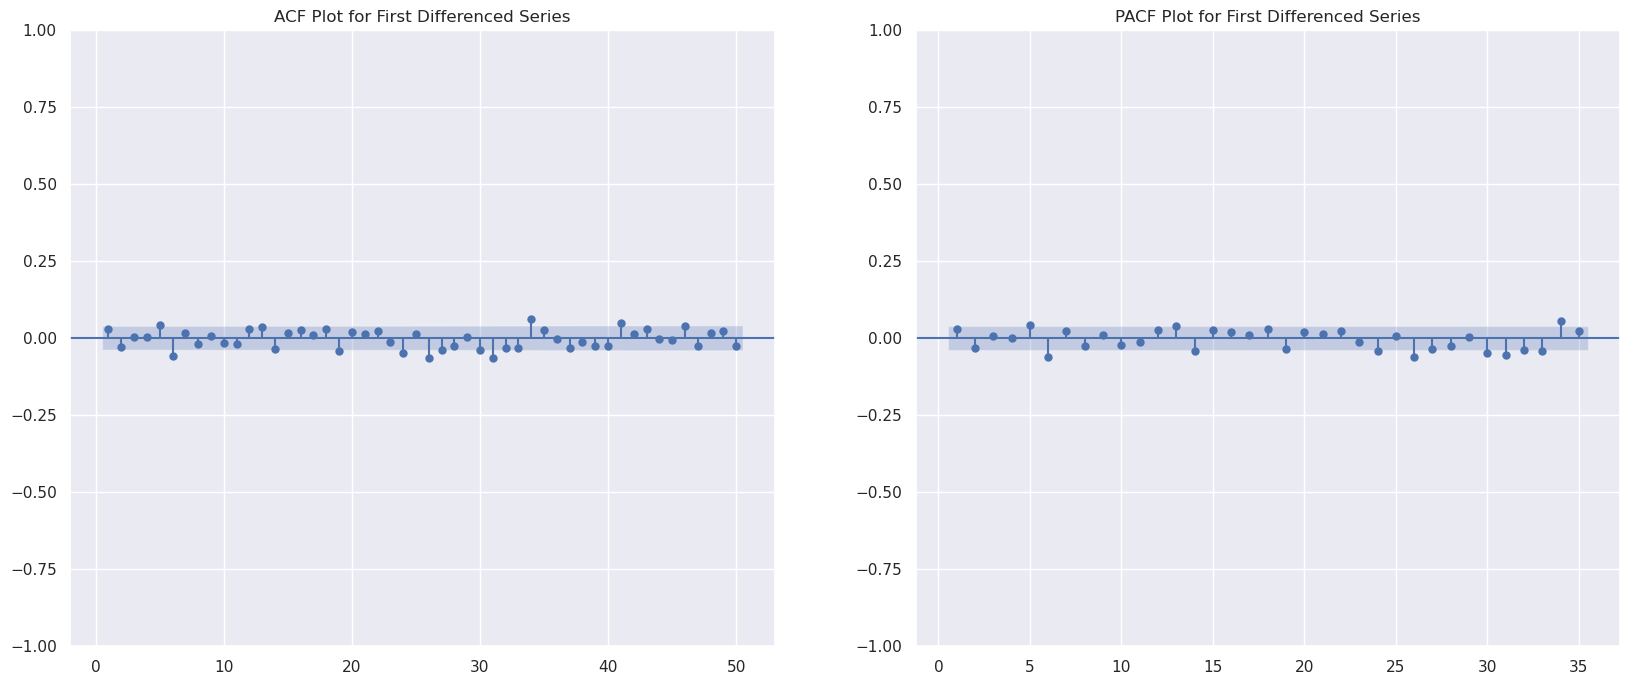

In [31]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
sgt.plot_acf(df_diff.infy[1:],ax=ax[0],title='ACF Plot for First Differenced Series',zero=False,lags=50);
sgt.plot_pacf(df_diff.infy[1:],ax=ax[1],title='PACF Plot for First Differenced Series',zero=False);

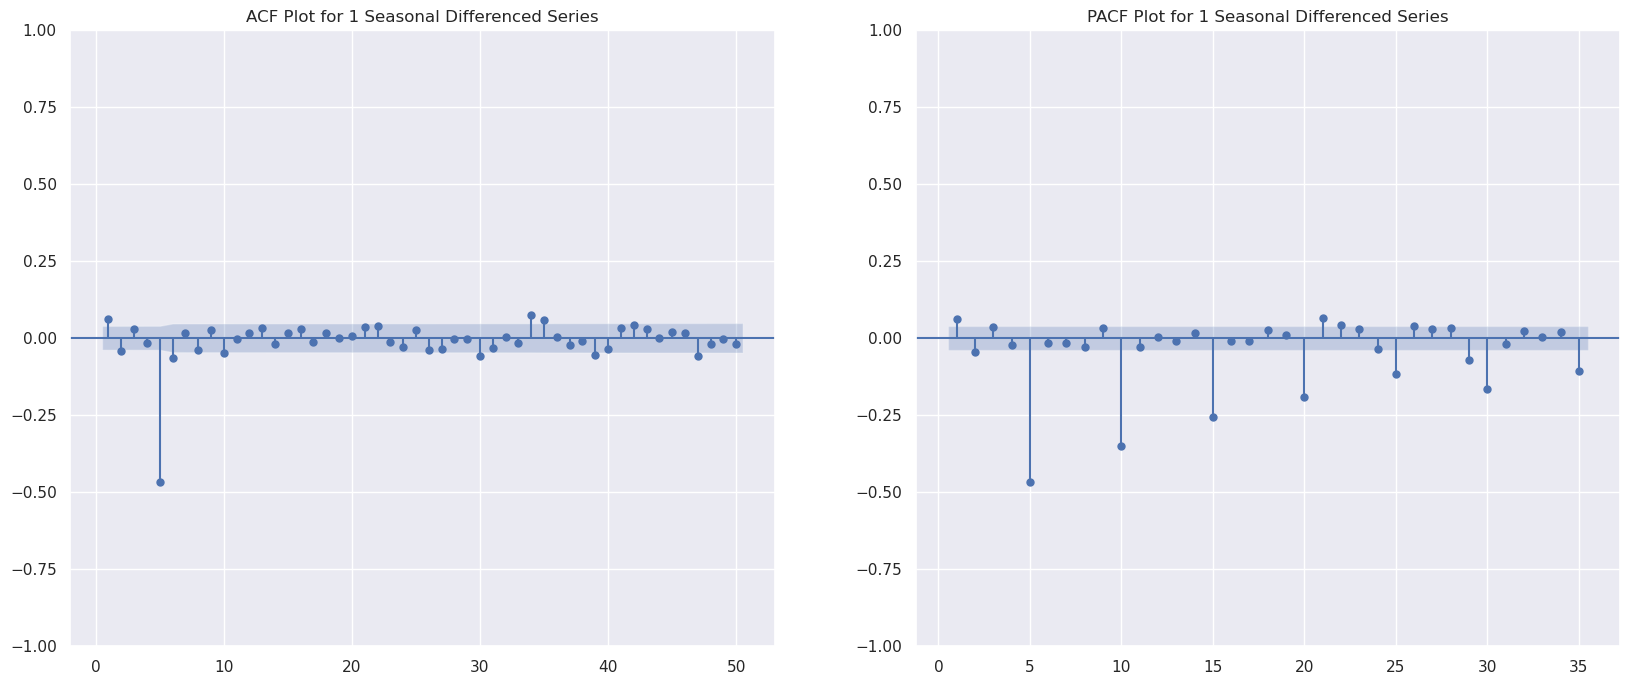

In [32]:
fig, ax = plt.subplots(1,2,figsize=(20,8))
sgt.plot_acf(df_seasonal_diff.infy[7:],ax=ax[0],title='ACF Plot for 1 Seasonal Differenced Series',zero=False,lags=50);
sgt.plot_pacf(df_seasonal_diff.infy[7:],ax=ax[1],title='PACF Plot for 1 Seasonal Differenced Series',zero=False);

We can observe seasonality at period of 7

# Seasonal Decompose

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

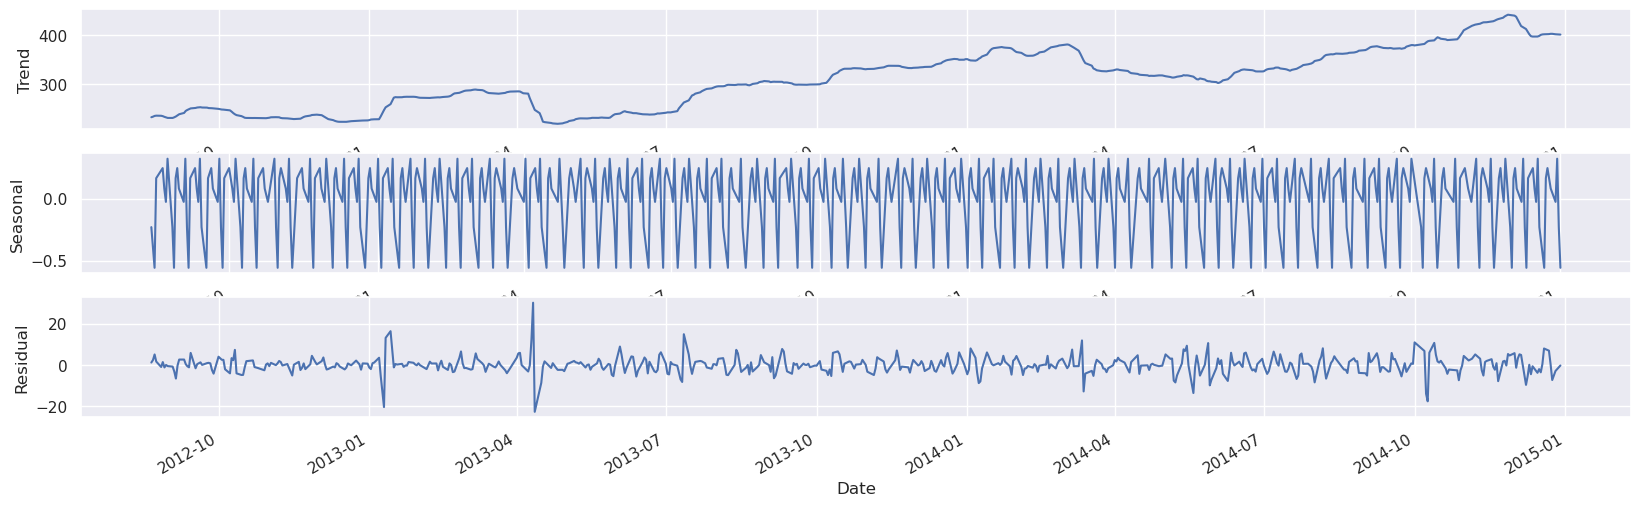

In [34]:
fig , (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,6))
decompose = seasonal_decompose(df.infy[:'2015-01-01'],model='additive',period=7)
decompose.trend.plot(ax=ax1)
ax1.set_ylabel('Trend')
decompose.seasonal.plot(ax=ax2)
ax2.set_ylabel("Seasonal")
decompose.resid.plot(ax=ax3)
ax3.set_ylabel("Residual")
plt.show()

# Log Likelihood Ratio Test

In [35]:
def LLR_test(mod_1, mod_2, df):
    from scipy.stats import chi2
    l1=mod_1.llf
    l2=mod_2.llf
    p=chi2.sf(2*(l2-l1), df).round(3)
    return p

# Modelling

## ARIMA
### Searching for best model

In [36]:
model_sarima010111 = SARIMAX(df_train.infy,order=(0,1,0),seasonal_order=(1,1,1,5))
result_sarima010111 = model_sarima010111.fit()
result_sarima010111.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73104D+00    |proj g|=  9.81660D-02

At iterate    5    f=  3.68523D+00    |proj g|=  6.07036D-03


 This problem is unconstrained.



At iterate   10    f=  3.68267D+00    |proj g|=  5.47755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   4.871D-06   3.683D+00
  F =   3.6826658171602760     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                infy   No. Observations:                 2077
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 5)   Log Likelihood               -7648.897
Date:                             Sun, 26 Feb 2023   AIC                          15303.794
Time:                                     23:16:19   BIC                          15320.701
Sample:                                          0   HQIC                         15309.991
                                            - 2077                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L5        0.0377      0.014      2.643      0.008       0.010       0.066
ma.S.L5       -0.9835      0.003   -294.989      0.000      -0.990      -0.977
sigma2        93.7579      1.032     90.866      0.000      91.736      95.780
===================================================================================
Ljung-Box (L1) (Q):                   1.97   Jarque-Bera (JB):             21270.20
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               6.05   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
auto_arima_model = auto_arima(
    df_train.infy,
    start_p=0,
    start_q=0,
    start_P =0,
    start_Q= 0,
    test="adf",
    max_p=9,
    max_q=9,
    m=5,  # frequency of series
    d=1,  # determine 'd'
    seasonal=True,  # no seasonality
    D=1,
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=16601.347, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=16048.235, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=16602.118, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=15773.912, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=15771.913, Time=0.30 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=16046.251, Time=0.18 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=15773.912, Time=0.41 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=15774.835, Time=0.85 sec
 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=15773.909, Time=0.76 sec

Best model:  ARIMA(0,1,0)(2,1,0)[5]          
To

In [38]:
df_train.head()

,wipro,bse,infy,tcs
,,,,
Date,,,,
2012-08-14,121.136482,17728.199219,227.483154,511.784698
2012-08-16,119.209625,17657.210938,225.950272,509.424896
2012-08-17,120.607864,17691.080078,229.577423,515.334656
2012-08-21,121.204697,17885.259766,235.010757,523.786255
2012-08-22,120.795441,17846.859375,237.192886,521.224670


# SARIMA(0,1,0)(1,1,1)[5]

<AxesSubplot:xlabel='Date'>

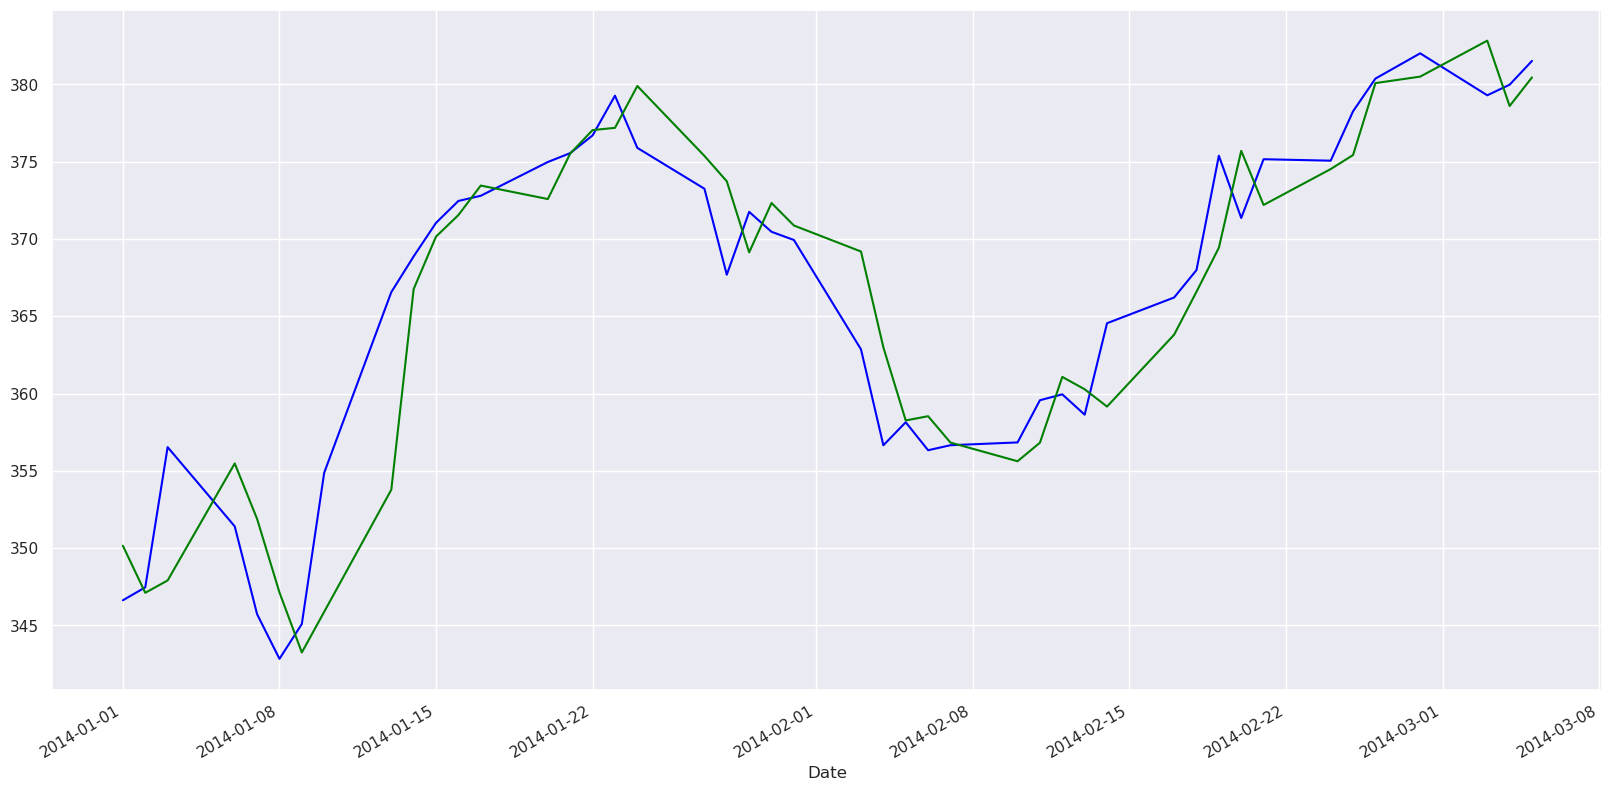

In [39]:
df_train['2014-01-01':'2014-03-05'].infy.plot(color='blue')
result_sarima010111.predict(dynamic=False,start='2014-01-01',end='2014-03-05').plot(figsize=(20,10),color='green')

In [40]:
y_pred_010 = result_sarima010111.predict(start=2077,end=2596,exog=df_test[['bse','wipro','tcs']])
y_pred_010.index = df_test.index

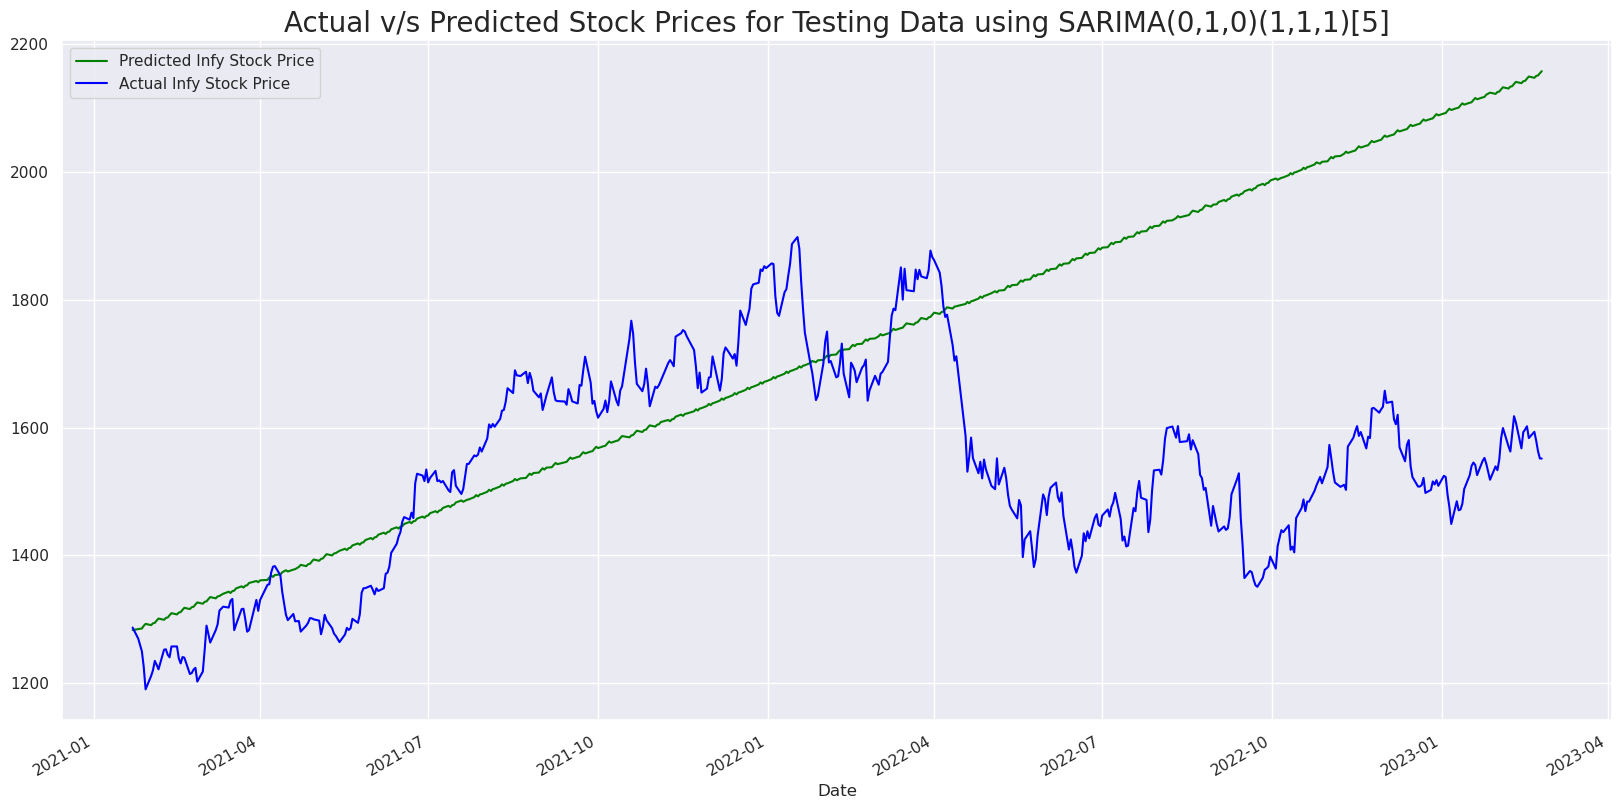

In [41]:
y_pred_010.plot(figsize=(20,10),color='green',label='Predicted Infy Stock Price')
df_test.infy.plot(color='blue',label='Actual Infy Stock Price')
plt.legend()
plt.title('Actual v/s Predicted Stock Prices for Testing Data using SARIMA(0,1,0)(1,1,1)[5]',size=20)
plt.show()

# ARIMAX

In [42]:
df_train

,wipro,bse,infy,tcs
,,,,
Date,,,,
2012-08-14,121.136482,17728.199219,227.483154,511.784698
2012-08-16,119.209625,17657.210938,225.950272,509.424896
2012-08-17,120.607864,17691.080078,229.577423,515.334656
2012-08-21,121.204697,17885.259766,235.010757,523.786255
2012-08-22,120.795441,17846.859375,237.192886,521.224670
...,...,...,...,...
2021-01-15,432.035248,49034.671875,1291.117310,3098.357910
2021-01-18,425.284698,48564.269531,1259.009644,3086.093262


In [43]:
auto_arimax_model = auto_arima(
    df_train.infy,
    X=df_train[['bse','wipro','tcs']],
    start_p=0,
    start_q=0,
    start_P=0,
    start_Q=0,
    test="adf",
    max_p=9,
    max_q=9,
    m=5,  # frequency of series
    d=1,  # determine 'd'
    D=1,
    seasonal=True,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=15823.598, Time=1.18 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=15244.847, Time=2.19 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=3.19 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=15820.794, Time=0.59 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=14938.702, Time=4.13 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=5.15 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=2.88 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=14945.803, Time=1.33 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=14939.634, Time=5.06 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=14939.633, Time=3.64 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=14938.313, Time=3.58 sec
 ARIMA(0,1,1)(1,1,0)[5]             : AIC=15244.600, Time=1.83 sec
 ARIMA(0,1,1)(2,1,1)[5]             : AIC=inf, Time=3.94 sec
 ARIMA(0,1,1)(1,1,1)[5]             : AIC=inf, Time=3.20 sec
 ARIMA(0,1,2)(2,1,0)[5]             : AIC=14939.6

In [44]:
best_model=[]
for p in range(0, 3):
    for q in range(0, 3):
        for P in range(0,3):
            for Q in range(0,3):
                order=(p,1,q)
                seasonal_order= (P,1,Q,5)
                model=SARIMAX(df_train.infy,exog=df_train[["bse", "wipro", "tcs"]], order=order,seasonal_order=seasonal_order)
                results=model.fit(disp=False)
                if (p==0 & q==0):
                    best=(p, q, results.aic)
                best_model.append((p, q,P,Q, results.aic))
                if (results.aic < best[2]):
                    best=(p, q, P,Q, results.aic)
                    print(best)
                else:
                    continue

(1, 0, 1, 2, 14480.039229359438)


In [45]:
len(best_model)

81

In [46]:
models = pd.DataFrame(columns=['p','q','P','Q','AIC'])

for p,q,P,Q,aic in best_model:
    row = {
        'p' : p,
        'q':q,
        'Q':Q,
        'P' : P,
        'AIC': aic
    }
    models = models.append(row,ignore_index=True)
models.sort_values(by='AIC')

,p,q,P,Q,AIC
23,0.0,2.0,1.0,2.0,14478.665767
41,1.0,1.0,1.0,2.0,14478.800816
59,2.0,0.0,1.0,2.0,14478.835265
14,0.0,1.0,1.0,2.0,14478.856227
32,1.0,0.0,1.0,2.0,14480.039229
...,...,...,...,...,...
63,2.0,1.0,0.0,0.0,15817.700214
45,1.0,2.0,0.0,0.0,15818.262377
9,0.0,1.0,0.0,0.0,15820.191382
27,1.0,0.0,0.0,0.0,15820.794017


## SARIMAX(0,1,2)(1,1,2)[5]

In [47]:
model_sarimax_012112 = SARIMAX(df_train.infy,exog=df_train[["bse", "wipro", "tcs"]], order=(0,1,2),seasonal_order=(1,1,2,5))
results_sarimax_012112 = model_sarimax_012112.fit(disp=False)
results_sarimax_012112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              infy   No. Observations:                 2077
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 5)   Log Likelihood               -7230.333
Date:                           Sun, 26 Feb 2023   AIC                          14478.666
Time:                                   23:22:41   BIC                          14529.388
Sample:                                        0   HQIC                         14497.257
                                          - 2077                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
bse            0.0086      0.000     21.451      0.000       0.008       0.009
wipro          0.9514      0.036     26.133      0.000       0.880       1.023
tcs            0.0338      0.001     29.883      0.000       0.032       0.036
ma.L1         -0.0845      0.017     -5.085      0.000      -0.117      -0.052
ma.L2         -0.0336      0.017     -1.997      0.046      -0.067      -0.001
ar.S.L5       -0.8748      0.064    -13.673      0.000      -1.000      -0.749
ma.S.L5       -0.0922      0.059     -1.562      0.118      -0.208       0.023
ma.S.L10      -0.9006      0.058    -15.509      0.000      -1.014      -0.787
sigma2        62.3939      0.712     87.663      0.000      60.999      63.789
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             56984.61
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               4.53   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX(0,1,1)(1,1,2)[5]

In [48]:
model_sarimax_011112 = SARIMAX(df_train.infy,exog=df_train[["bse", "wipro", "tcs"]], order=(0,1,1),seasonal_order=(1,1,2,5))
results_sarimax_011112 = model_sarimax_011112.fit(disp=False)
results_sarimax_011112.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                   infy   No. Observations:                 2077
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 5)   Log Likelihood               -7231.428
Date:                                Sun, 26 Feb 2023   AIC                          14478.856
Time:                                        23:22:44   BIC                          14523.943
Sample:                                             0   HQIC                         14495.382
                                               - 2077                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
bse            0.0086      0.000     21.572      0.000       0.008       0.009
wipro          0.9490      0.036     26.110      0.000       0.878       1.020
tcs            0.0341      0.001     30.436      0.000       0.032       0.036
ma.L1         -0.0876      0.016     -5.323      0.000      -0.120      -0.055
ar.S.L5       -0.8659      0.069    -12.502      0.000      -1.002      -0.730
ma.S.L5       -0.0994      0.064     -1.555      0.120      -0.225       0.026
ma.S.L10      -0.8918      0.063    -14.149      0.000      -1.015      -0.768
sigma2        62.4538      0.691     90.321      0.000      61.099      63.809
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             56368.28
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.52   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
LLR_test(results_sarimax_012112,results_sarimax_011112,1)

1.0

SARIMAX(0,1,2)(1,1,2)[5] is better than SARIMAX(0,1,1)(1,1,2)[5]

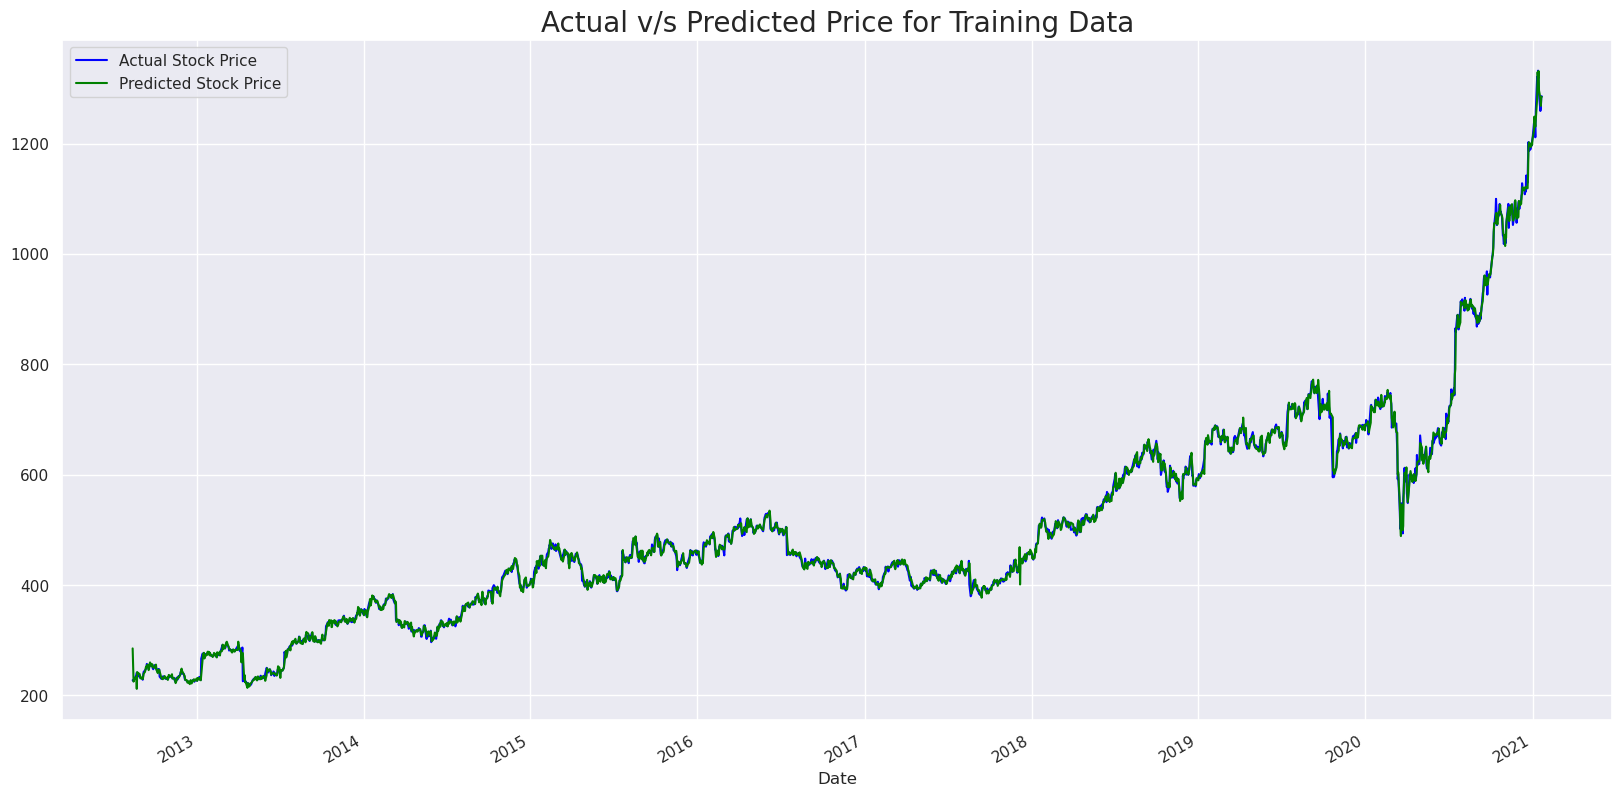

In [50]:
df_train.infy.plot(color='blue', label='Actual Stock Price')
results_sarimax_012112.predict(exog=df_train[['bse','wipro','tcs']]).plot(color='green',figsize=(20,10),label='Predicted Stock Price')
plt.title('Actual v/s Predicted Price for Training Data',size =20)
plt.legend()
plt.show()

In [51]:
df_train.tail()

,wipro,bse,infy,tcs
,,,,
Date,,,,
2021-01-15,432.035248,49034.671875,1291.117310,3098.357910
2021-01-18,425.284698,48564.269531,1259.009644,3086.093262
2021-01-19,424.052887,49398.289062,1264.192993,3128.588135
2021-01-20,438.490234,49792.121094,1285.693848,3169.837402
2021-01-21,439.426361,49624.761719,1285.502075,3137.834717


In [52]:
len(df_test)

520

In [53]:
df_test.head()

,wipro,bse,infy,tcs
,,,,
Date,,,,
2021-01-22,439.722717,48878.539062,1286.653809,3165.238281
2021-01-25,431.870544,48347.589844,1269.520142,3152.590332
2021-01-27,440.759796,47409.929688,1249.506958,3124.659424
2021-01-28,426.438171,46874.359375,1225.078369,3065.635986
2021-01-29,412.906738,46285.769531,1189.899414,2982.705811


In [54]:
y_pred = results_sarimax_012112.predict(start=2077,end=2596,exog=df_test[['bse','wipro','tcs']])
y_pred.index = df_test.index

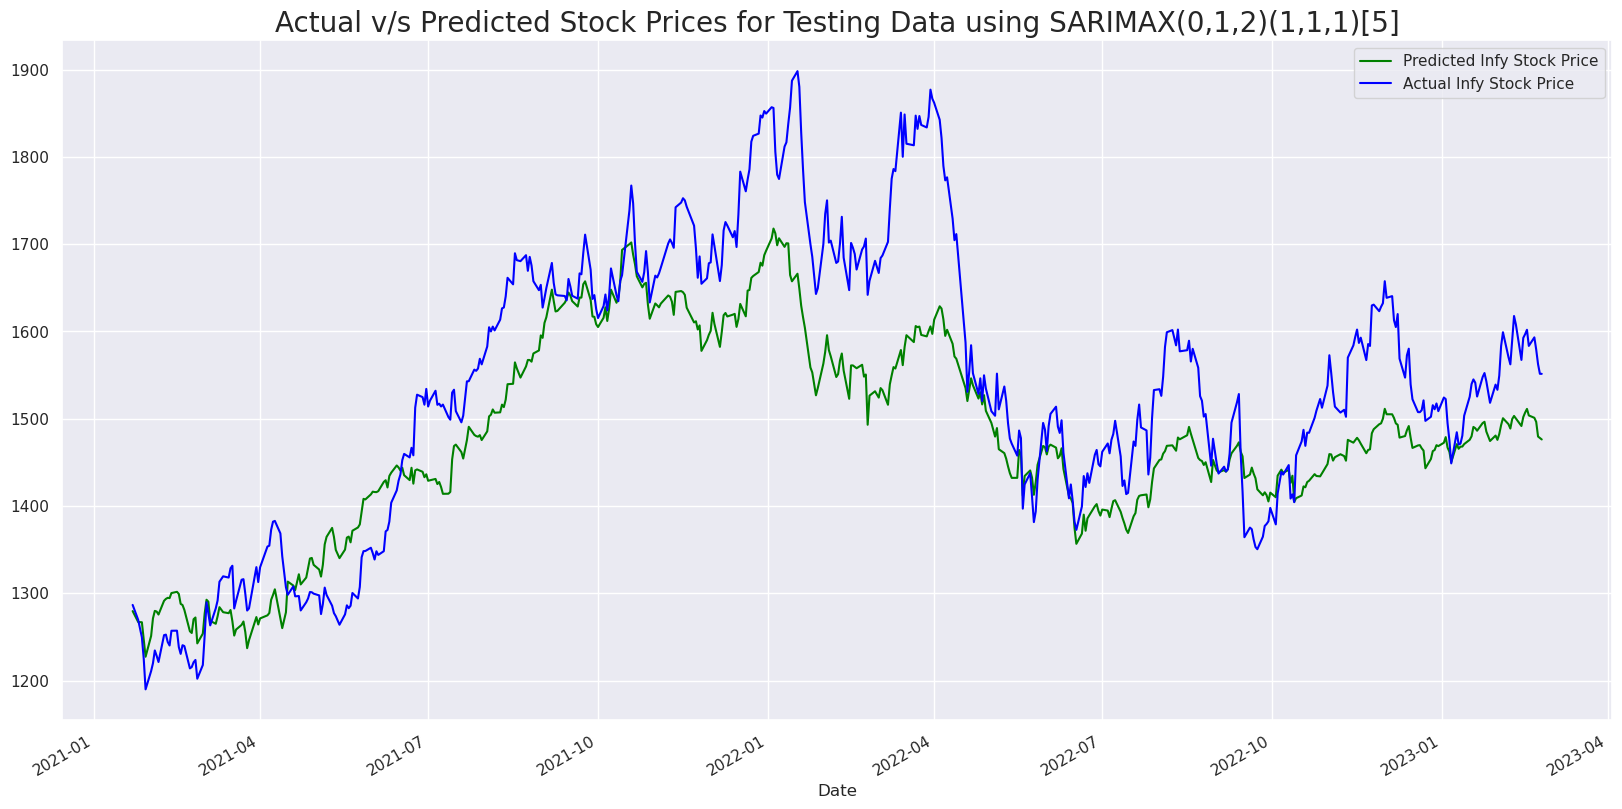

In [55]:
y_pred.plot(figsize=(20,10),color='green',label='Predicted Infy Stock Price')
df_test.infy.plot(color='blue',label='Actual Infy Stock Price')
plt.legend()
plt.title('Actual v/s Predicted Stock Prices for Testing Data using SARIMAX(0,1,2)(1,1,1)[5]',size=20)
plt.show()

In [56]:
from sklearn.metrics import r2_score ,mean_absolute_error as mae ,mean_absolute_percentage_error as mape

In [57]:
print(f'R2 Score: {r2_score(df_test.infy,y_pred)}')
print(f'Mean Absolute Error: {mae(df_test.infy,y_pred)}')
print(f'Mean Absolute Percentage Error: {mape(df_test.infy,y_pred) * 100} %')

R2 Score: 0.6762094742922069
Mean Absolute Error: 74.7063775101718
Mean Absolute Percentage Error: 4.679738623568319 %
